# DLthon - 길찾은 오리들
## Base Settings

In [1]:
# importing the libraries
import keras, tensorflow as tf
import pathlib
from keras import layers

# keras.mixed_precision.set_global_policy('mixed_float16')

# importing the modules
import basemodels, topmodels, utils

2025-01-19 17:21:39.843330: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-19 17:21:39.853326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737274899.864018   83350 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737274899.866905   83350 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 17:21:39.878885: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# loading the dataset
base_dir = pathlib.Path('jellyfish/Train_Test_Valid')

train_dataset = keras.utils.image_dataset_from_directory(
    base_dir / "train",
    image_size = (224, 224),
    batch_size = 64,
    label_mode='categorical')

val_dataset = keras.utils.image_dataset_from_directory(
    base_dir / "valid",
    image_size = (224, 224),
    batch_size = 64,
    label_mode='categorical')

test_dataset = keras.utils.image_dataset_from_directory(
    base_dir / "test",
    image_size = (224, 224),
    batch_size = 64,
    label_mode='categorical')

Found 900 files belonging to 6 classes.


I0000 00:00:1737274903.059858   83350 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9571 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 39 files belonging to 6 classes.
Found 40 files belonging to 6 classes.




## Basemodel

여기에 ResNet50 결과 입력

## First Trial: EfficientNetV2L + Top1
### Designing the Model

In [3]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# designing the model

def eV2L_top1(): # this can be adjusted to be hyper-tunable
    inputs = keras.Input(shape=(224, 224, 3))
    # x = data_augmentation(inputs)
    x = basemodels.EV2L((224, 224, 3))(inputs, training=False)
    x = topmodels.simple_cnn(x)
    outputs = layers.Dense(6, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    
    model.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['accuracy'])
    
    return model

In [4]:
eV2L_top1().summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-l (Functional)   │ (None, 7, 7, 1280)     │   117,746,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,056,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,804,966 (510.43 MB)

 Trainable params: 16,058,118 (61.26 MB)

 Non-trainable params: 117,746,848 (449.17 MB)

In [5]:
eV2L_top1_history = eV2L_top1().fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[
        utils.callback_savemodel('eV2L_top1.keras'),
        utils.callback_earlystop(80)
    ],
)

Epoch 1/200


I0000 00:00:1737274965.150827   83493 service.cc:148] XLA service 0x7f3304002520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737274965.150876   83493 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-01-19 17:22:46.015694: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737274969.066687   83493 cuda_dnn.cc:529] Loaded cuDNN version 90600
I0000 00:00:1737274996.275497   83493 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.1844 - loss: 35.7017 - val_accuracy: 0.2308 - val_loss: 2.6963
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.3231 - loss: 2.0410 - val_accuracy: 0.2308 - val_loss: 2.0528
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.3065 - loss: 1.9396 - val_accuracy: 0.2051 - val_loss: 2.4193
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.2959 - loss: 1.9967 - val_accuracy: 0.2051 - val_loss: 3.6809
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.2767 - loss: 2.3244 - val_accuracy: 0.1538 - val_loss: 3.4227
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.2706 - loss: 2.2554 - val_accuracy: 0.1795 - val_loss: 3.6617
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step - accuracy: 0.3007 - loss: 2.2351 - val_accuracy: 0.2821 - val_loss: 3.1670
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.3150 - loss: 1.9889 - val_accuracy: 0.2564 

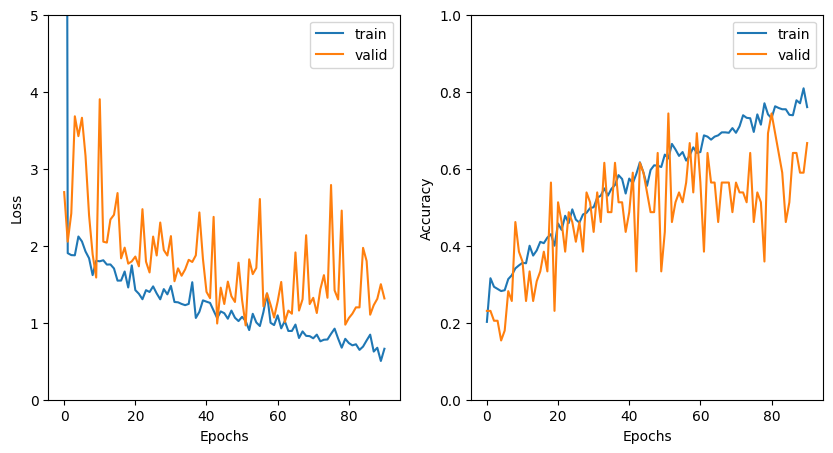

In [6]:
utils.plot_history(eV2L_top1_history, (0, 5), (0, 1))

In [7]:
eV2L_top1_best = keras.models.load_model('eV2L_top1.keras')
test_loss, test_acc = eV2L_top1_best.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}%, Test loss: {test_loss:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.7000 - loss: 1.0903
Test accuracy: 0.70%, Test loss: 1.09


## Second Trial: MobileNetV2 + Top1

In [8]:
def mV2_top1():
    inputs = keras.Input(shape=(224, 224, 3))
    x = basemodels.MV2()(inputs, training=False)
    x = topmodels.simple_cnn(x)
    outputs = layers.Dense(6, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    model.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['accuracy'])

    return model

mV2_top1_history = mV2_top1().fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[
        utils.callback_savemodel('mV2_top1.keras'),
        utils.callback_earlystop(80)
    ],
)

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 560ms/step - accuracy: 0.2069 - loss: 53.4236 - val_accuracy: 0.2051 - val_loss: 3.8961
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3845 - loss: 2.1796 - val_accuracy: 0.2051 - val_loss: 2.4569
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3747 - loss: 1.8700 - val_accuracy: 0.3333 - val_loss: 1.9527
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4571 - loss: 1.6141 - val_accuracy: 0.2051 - val_loss: 2.6990
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3794 - loss: 2.0632 - val_accuracy: 0.3590 - val_loss: 1.5917
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4536 - loss: 1.5925 - val_accuracy: 0.1795 - val_loss: 4.5039
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4227 - loss: 2.3560 - val_accuracy: 0.2564 - val_loss: 4.0093
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4719 - loss: 1.9549 - val_accuracy:

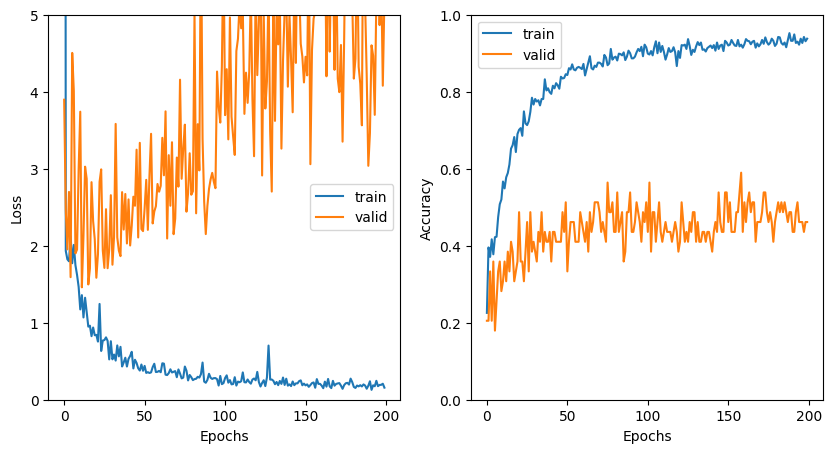

In [9]:
utils.plot_history(mV2_top1_history)

In [11]:
mV2_top1_best = keras.models.load_model('mV2_top1.keras')
test_loss, test_acc = mV2_top1_best.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}%, Test loss: {test_loss:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 4.4128
Test accuracy: 0.50%, Test loss: 4.41
